Implementation of the FaSTM $\forall$ N algorithm, from the initial transaction data up to the community detection. It is implemented in a less efficient and scalable way than the code of the authors, but it is probably more transparent and understandable.

Repo of the paper: https://github.com/mhaseebtariq/fastman/tree/main

# Libraries and paths

In [1]:
import os
import igraph as ig
import polars as pl
from datetime import datetime, timedelta
import matplotlib.pyplot as plt

Useful `polars` references:
- Python API reference: https://docs.pola.rs/api/python/stable/reference/index.html
- Getting started guide: https://docs.pola.rs/user-guide/getting-started/
- Key differences with `pandas`: https://docs.pola.rs/user-guide/migration/pandas/

In [2]:
# import os

# # Crear la estructura de directorios
# base_path = os.path.join("..", "data")
# directories = ["partition", "joins", "nodes", "edges", "co_ocurrences", "second_order"]

# for directory in directories:
#     os.makedirs(os.path.join(base_path, directory), exist_ok=True)

# print("Created the directory structure.")


In [3]:
# General location for the data
data_location = os.path.join("..", "data")

# Set location where we will save the partitions
partitions_location = os.path.join(data_location, 'partition')

# Create a location where we will save the joins
joins_location = os.path.join(data_location, "joins")

# Location of the nodes and the edges
nodes_location = os.path.join(data_location, "nodes")
edges_location = os.path.join(data_location, "edges")

co_occurrences_location = os.path.join(data_location, "co_ocurrences")
second_order_location = os.path.join(data_location, 'second_order')

# 0. Importing and preprocessing the transaction data

## Import

In [4]:
# # Code to create the subset a subset of data for faster computations

# import polars as pl

# # Set file paths
# input_file = "../data/HI-Small_Trans.parquet"  # Adjust the path if needed
# output_file = "../data/HI-Small_Trans_subset.parquet"

# # Parameters
# subset_fraction = 0.1  # 5% of the dataset
# batch_size = 500_000  # Load 500,000 rows at a time

# # Get total row count (for proportional sampling)
# total_rows = pl.scan_parquet(input_file).select(pl.count()).collect().item()
# subset_size = int(total_rows * subset_fraction)

# # Read the Parquet file lazily and sample
# df = pl.scan_parquet(input_file).collect().sample(n=subset_size, seed=42)

# # Save the subset as a Parquet file
# df.write_parquet(output_file)

# print(f"Subset created with {len(df)} rows and saved to {output_file}")


In [5]:
df = pl.read_parquet(os.path.join(data_location, 'HI-Small_Trans_subset.parquet')) # path for the subset
# df = pl.read_parquet(os.path.join(data_location, 'HI-Small_Trans.parquet'))  path of the whole dataset

In [6]:
df.head()

Timestamp,From Bank,Account,To Bank,Account.1,Amount Received,Receiving Currency,Amount Paid,Payment Currency,Payment Format,Is Laundering
str,i64,str,i64,str,f64,str,f64,str,str,i64
"""2022/09/01 14:51""",122332,"""808376670""",220504,"""808763050""",165.58,"""UK Pound""",165.58,"""UK Pound""","""Cash""",0
"""2022/09/02 12:05""",70,"""100428660""",2843,"""800C08F10""",1000.0,"""US Dollar""",1000.0,"""US Dollar""","""Cheque""",0
"""2022/09/07 22:23""",14,"""8035A5A50""",3,"""8035CB140""",4449.0,"""Yuan""",4449.0,"""Yuan""","""Credit Card""",0
"""2022/09/02 15:44""",14290,"""8028B20E0""",214100,"""80B5A8EF0""",24022.22,"""Euro""",24022.22,"""Euro""","""ACH""",0
"""2022/09/01 00:28""",12735,"""803109B90""",226951,"""80A633740""",2777.01,"""US Dollar""",2777.01,"""US Dollar""","""Cheque""",0


## Preprocessing

In [7]:
# Rename columns for clarity
names = {'id': 'id',
         'Timestamp': 'date',
         'From Bank': 'source_bank',
         'Account': 'source_account',
         'To Bank': 'destination_bank',
         'Account.1': 'destination_account',
         'Amount Received': 'amount_received',
         'Receiving Currency': 'currency_received',
         'Amount Paid': 'amount_sent',
         'Payment Currency': 'currency_sent',
         'Payment Format': 'payment_method',
         'Is Laundering': 'is_laundering'}

df = df.rename(names)

Note that polars' unit of time when converting a datetime column into the time passed since the 1st of January 1970 is microseconds: https://docs.pola.rs/api/python/stable/reference/api/polars.datatypes.Datetime.html

In [8]:
def timestamp_date(df):
    """Transforms date into datetime format + makes a timestamp column (Unix timestamp)"""
    df = df.with_columns(
        pl.col("date")
        .str.strptime(pl.Datetime, "%Y/%m/%d %H:%M")  # Convert string to Datetime
        .dt.timestamp()  # Convert Datetime to Unix timestamp
        .alias("timestamp"))
    
    df = df.with_columns((pl.col("timestamp") // 10**6).alias('timestamp'))
  
    df = df.with_columns(
        pl.col("date")
        .str.strptime(pl.Datetime, "%Y/%m/%d %H:%M")
        .dt.date())
    return df

df = timestamp_date(df)

df.head()

date,source_bank,source_account,destination_bank,destination_account,amount_received,currency_received,amount_sent,currency_sent,payment_method,is_laundering,timestamp
date,i64,str,i64,str,f64,str,f64,str,str,i64,i64
2022-09-01,122332,"""808376670""",220504,"""808763050""",165.58,"""UK Pound""",165.58,"""UK Pound""","""Cash""",0,1662043860
2022-09-02,70,"""100428660""",2843,"""800C08F10""",1000.0,"""US Dollar""",1000.0,"""US Dollar""","""Cheque""",0,1662120300
2022-09-07,14,"""8035A5A50""",3,"""8035CB140""",4449.0,"""Yuan""",4449.0,"""Yuan""","""Credit Card""",0,1662589380
2022-09-02,14290,"""8028B20E0""",214100,"""80B5A8EF0""",24022.22,"""Euro""",24022.22,"""Euro""","""ACH""",0,1662133440
2022-09-01,12735,"""803109B90""",226951,"""80A633740""",2777.01,"""US Dollar""",2777.01,"""US Dollar""","""Cheque""",0,1661992080


In this graph, each row is a transaction. Note, however, that there is one requirement of the data that must be created for running the FaSTM $\forall$ N algorithm_ a unique identifier for a transaction. We can create this unique identifier just from the current index.

In [9]:
df = df.with_row_index(name="id", offset=1)  # Start IDs from 1

df.head()

id,date,source_bank,source_account,destination_bank,destination_account,amount_received,currency_received,amount_sent,currency_sent,payment_method,is_laundering,timestamp
u32,date,i64,str,i64,str,f64,str,f64,str,str,i64,i64
1,2022-09-01,122332,"""808376670""",220504,"""808763050""",165.58,"""UK Pound""",165.58,"""UK Pound""","""Cash""",0,1662043860
2,2022-09-02,70,"""100428660""",2843,"""800C08F10""",1000.0,"""US Dollar""",1000.0,"""US Dollar""","""Cheque""",0,1662120300
3,2022-09-07,14,"""8035A5A50""",3,"""8035CB140""",4449.0,"""Yuan""",4449.0,"""Yuan""","""Credit Card""",0,1662589380
4,2022-09-02,14290,"""8028B20E0""",214100,"""80B5A8EF0""",24022.22,"""Euro""",24022.22,"""Euro""","""ACH""",0,1662133440
5,2022-09-01,12735,"""803109B90""",226951,"""80A633740""",2777.01,"""US Dollar""",2777.01,"""US Dollar""","""Cheque""",0,1661992080


## Partitioning the data by days of the transaction

For the first step of the FaSTM $\forall$ N, we need to do a Cartesian product of rows in a time window of 1 day (as in the paper, they state that "The transactions are processed iteratively, one day at a time"), which can exponentially increase the number of rows and not fit in the memory. To that end, below we partition the dataset using the `polars` method `write_parquet`, which creates a "hive partitioned parquet dataset" according to the specified column (https://docs.pola.rs/user-guide/io/hive/#writing-hive-partitioned-data).

In [10]:
# Write Hive-partitioned Parquet files
df.write_parquet(
    partitions_location,
    partition_by=["date"],  # Partition by this column
) 

Example of reading the hived dataset using polars (https://docs.pola.rs/user-guide/io/hive/#scanning-hive-partitioned-data):

In [11]:
df = pl.scan_parquet(partitions_location).collect()

df.head()

id,date,source_bank,source_account,destination_bank,destination_account,amount_received,currency_received,amount_sent,currency_sent,payment_method,is_laundering,timestamp
u32,date,i64,str,i64,str,f64,str,f64,str,str,i64,i64
1,2022-09-01,122332,"""808376670""",220504,"""808763050""",165.58,"""UK Pound""",165.58,"""UK Pound""","""Cash""",0,1662043860
5,2022-09-01,12735,"""803109B90""",226951,"""80A633740""",2777.01,"""US Dollar""",2777.01,"""US Dollar""","""Cheque""",0,1661992080
7,2022-09-01,17615,"""803E3C970""",3514,"""807FCB430""",269.11,"""Euro""",269.11,"""Euro""","""Credit Card""",0,1662009660
10,2022-09-01,28827,"""808AE5290""",11318,"""813A89180""",334.77,"""US Dollar""",334.77,"""US Dollar""","""Cheque""",0,1661999340
11,2022-09-01,1601,"""8009688C0""",27241,"""802A8A8A0""",3316.76,"""Euro""",3316.76,"""Euro""","""Credit Card""",0,1662049500


This is just the initial dataset, but read from a partitioned structure!

In [12]:
# Remove the data frame for memory efficiency
del df

# 1. Temporal graph creation ("Temporal Graph of Sequential Transactions")

## 1.1. Set FaSTM $\forall$ N parameters

In [13]:
# Time window in days
window = 2
# Minimum edge of the weights for considering them
min_edge_weights = 0.5

## 1.2. Sequential inner joins

Now, we will iterate over the different transaction dates that we have in our dataset (ensures that at any point we only load a manageable subset of the data into memory). The code below implements the **Definition 1** in Tariq and Hassani (2024), together with pages 7 and 8 of their paper. Guideline of the operations done below:

1. **Partition Discovery:**  The code begins by listing all subdirectories under the `partition` folder and extracting the dates. This allows us to work one day at a time (or over a window of days).

2. **Window Definition:** For each transaction date, a window is defined (for example, the current day plus one extra day). This "extra" is set by the `window` parameter ($\Delta w$), which is not disclosed by the authors (they only state that they use a "very consdervative *undisclosed* value for $\Delta w$). Only partitions (files) within this window are read. Note that by increasing this parameter, the number of inner joins will significantly increase.

3. **Lazy Scanning:** To keep the memory footprint low, we use `pl.scan_parquet` on only the necessary partitions to ensure that we are not reading the whole dataset within the time window. In lazy mode nothing is executed (i.e., the dataset is not materialized) until we call `collect()`. See: https://docs.pola.rs/api/python/stable/reference/lazyframe/api/polars.LazyFrame.collect.html#polars.LazyFrame.collect

4. **Filtering and Splitting Data:** The same lazy DataFrame is used to define both “right” and “left” subsets. The left subset is filtered further by a timestamp criterion (e.g. rows with `Timestamp` less than the maximum timestamp of the current date). Here, the "left" subset will contain the source edges $s$, while the "right" subset will contain the destination edges $d$ (see definition 1 in the paper).

5. **Renaming Columns:** To avoid collisions during the join, all columns in the left subset are renamed by appending a suffix.

6. **Joining and Calculating Time Delta:**
   - An inner join is then performed based on the desired key: we join “Destination Account_left” from the left side (i.e., the beneficiary of the source node, $b_s$) to a “Source Account” from the right side (the "from" account in the destination transaction, $f_d$).
   - After the join, a new column “delta” is calculated (as the difference between timestamps) and filtered so that only positive deltas are kept (i.e., we only keep those "right" transactions which happen after the "left").

7. **Collecting with Streaming:**  
   - The final lazy query is executed with `collect(streaming=True)`, which instructs Polars to process data in batches rather than all at once—helping to keep memory usage low (https://docs.pola.rs/user-guide/concepts/_streaming/).  
   - The batch size can be adjusted: see https://docs.pola.rs/api/python/dev/reference/api/polars.Config.set_streaming_chunk_size.html.

8. **Output:** The joined result is written out to disk as a parquet file under a directory named for the current staging date.

In [14]:
# We get a sorted list of transaction dates from the partition directories.
all_partitions = os.listdir(partitions_location)
dates = sorted([
    partition.split("=")[1] 
    for partition in all_partitions 
    if partition.startswith("date=")  # Note that the partition directories start with "Date=" (the column where we stored the date above)
])

print(dates)

['2022-09-01', '2022-09-02', '2022-09-03', '2022-09-04', '2022-09-05', '2022-09-06', '2022-09-07', '2022-09-08', '2022-09-09', '2022-09-10', '2022-09-11', '2022-09-12', '2022-09-13', '2022-09-14', '2022-09-15', '2022-09-16', '2022-09-17', '2022-09-18']


In [15]:
total_rows_joined_dataset = 0

for transaction_date in dates:

    # Define the start date (window start) for filtering right partitions
    current_date = datetime.strptime(transaction_date, "%Y-%m-%d")
    # Define the end date (window end) for filtering right partitions
    end_date = current_date + timedelta(days=window)
    end_date_str = end_date.strftime("%Y-%m-%d")  # Convert end date to string
    
    # Determine which partitions fall in the window: dates between current_date and end_date, inclusive
    window_dates = [d for d in dates if transaction_date <= d <= end_date_str]
    
    # Build the file paths for these partitions
    right_paths = [
        os.path.join(partitions_location, f"date={d}")
        for d in window_dates
    ]
    
    # Read the "right" side data lazily from only the required partitions
    right = pl.scan_parquet(right_paths)
    
    # Define a maximum timestamp for the current date (e.g., all transactions with
    # a timestamp less than the end of the day)
    max_ts_time = datetime.combine(current_date, datetime.max.time())
    max_ts = max_ts_time.timestamp()  # Convert to a timestamp
    
    # Filter the "left" side: only rows from the window with Timestamp before max_ts
    left = right.filter(pl.col("timestamp") < max_ts)
    
    # Rename the columns in the left DataFrame so that after the join left and right have distinct names
    left = left.rename({col: f"{col}_left" for col in left.columns})
    
    # Create the right join key to preserve the original source account (just a "trick")
    # However, note that the right source account should match to the left destination
    # account
    right = right.with_columns(pl.col("source_account").alias("source_account_right"))

    # Perform the inner join on the left and right data frames
    join_expr = left.join(
        right, 
        left_on="destination_account_left",  # Destination account of the left data frame
        right_on="source_account_right",  # Source account of the right data frame
        how="inner"
    )
    
    # Calculate the time delta between the joined timestamps
    join_expr = join_expr.with_columns(
        (pl.col("timestamp") - pl.col("timestamp_left")).alias("delta")
    )
    
    # Only keep rows where the delta is positive (right transaction happens after left)
    join_expr = join_expr.filter(pl.col("delta") > 0)
    
    # Use streaming mode (if supported) to keep the memory footprint low.
    # The lazy query will process data in batches.
    join_df = join_expr.collect(streaming=True)
    
    # Write out the result for the current transaction_date, partitioning the results
    # by the transaction_date
    
    join_df = join_df.with_columns(
        pl.lit(transaction_date).alias("staging_date"))  # Add the staging date as a column
    
    join_df.write_parquet(
        joins_location,
        partition_by=["staging_date"],  # Partition by the staging column
    ) 

    total_rows_joined_dataset += join_df.height
    print(f"Processed transaction_date {transaction_date} with {join_df.height} joined rows.")

print(f'Total rows of the joined data frame: {total_rows_joined_dataset}')

Processed transaction_date 2022-09-01 with 50407 joined rows.
Processed transaction_date 2022-09-02 with 228087 joined rows.
Processed transaction_date 2022-09-03 with 5835 joined rows.


/var/folders/06/b6hq4_md0n50pkq6_5j8l7yc0000gn/T/ipykernel_40860/1652902956.py:32: PerformanceWarning: Determining the column names of a LazyFrame requires resolving its schema, which is a potentially expensive operation. Use `LazyFrame.collect_schema().names()` to get the column names without this warning.
  left = left.rename({col: f"{col}_left" for col in left.columns})
/var/folders/06/b6hq4_md0n50pkq6_5j8l7yc0000gn/T/ipykernel_40860/1652902956.py:57: DeprecationWarning: The argument `streaming=True` is deprecated and is being replaced by the `engine` argument.
  join_df = join_expr.collect(streaming=True)
/var/folders/06/b6hq4_md0n50pkq6_5j8l7yc0000gn/T/ipykernel_40860/1652902956.py:57: DeprecationWarning: The old streaming engine is being deprecated and will soon be replaced by the new streaming engine. Starting Polars version 1.23.0 and until the new streaming engine is released, the old streaming engine may become less usable. For people who rely on the old streaming engine, it 

Processed transaction_date 2022-09-04 with 7949 joined rows.
Processed transaction_date 2022-09-05 with 21613 joined rows.
Processed transaction_date 2022-09-06 with 21352 joined rows.
Processed transaction_date 2022-09-07 with 23450 joined rows.
Processed transaction_date 2022-09-08 with 17631 joined rows.
Processed transaction_date 2022-09-09 with 178858 joined rows.
Processed transaction_date 2022-09-10 with 888 joined rows.
Processed transaction_date 2022-09-11 with 6 joined rows.
Processed transaction_date 2022-09-12 with 4 joined rows.
Processed transaction_date 2022-09-13 with 3 joined rows.
Processed transaction_date 2022-09-14 with 0 joined rows.
Processed transaction_date 2022-09-15 with 0 joined rows.
Processed transaction_date 2022-09-16 with 1 joined rows.
Processed transaction_date 2022-09-17 with 0 joined rows.
Processed transaction_date 2022-09-18 with 0 joined rows.
Total rows of the joined data frame: 556084


Note that, depending on the amount of RAM of your computer, you will not be able to read the whole data frame (there are more than 50M rows and 13 * 2 + 1 columns, with $\Delta w = 2$)! For that reason, below we only read one parquet file as an example.

In [16]:
# Read the final results
df_joins_2022_09_01 = pl.read_parquet(os.path.join(joins_location, "staging_date=2022-09-01/00000000.parquet"))

df_joins_2022_09_01.head()

id_left,date_left,source_bank_left,source_account_left,destination_bank_left,destination_account_left,amount_received_left,currency_received_left,amount_sent_left,currency_sent_left,payment_method_left,is_laundering_left,timestamp_left,id,date,source_bank,source_account,destination_bank,destination_account,amount_received,currency_received,amount_sent,currency_sent,payment_method,is_laundering,timestamp,delta,staging_date
u32,date,i64,str,i64,str,f64,str,f64,str,str,i64,i64,u32,date,i64,str,i64,str,f64,str,f64,str,str,i64,i64,i64,str
317995,2022-09-01,28255,"""80E10B8B0""",28255,"""80E10B8B0""",7.48,"""US Dollar""",7.48,"""US Dollar""","""Reinvestment""",0,1661991720,40,2022-09-01,28255,"""80E10B8B0""",238038,"""813967F00""",444.58,"""US Dollar""",444.58,"""US Dollar""","""Cheque""",0,1662064440,72720,"""2022-09-01"""
34239,2022-09-01,28255,"""80E10B8B0""",28255,"""80E10B8B0""",508942.03,"""US Dollar""",508942.03,"""US Dollar""","""Reinvestment""",0,1661992020,40,2022-09-01,28255,"""80E10B8B0""",238038,"""813967F00""",444.58,"""US Dollar""",444.58,"""US Dollar""","""Cheque""",0,1662064440,72420,"""2022-09-01"""
90222,2022-09-01,8,"""80926C220""",24941,"""809D8FB30""",94.23,"""Canadian Dollar""",94.23,"""Canadian Dollar""","""Wire""",0,1662003120,43,2022-09-01,24941,"""809D8FB30""",24941,"""809D8FB30""",18.28,"""Canadian Dollar""",18.28,"""Canadian Dollar""","""Reinvestment""",0,1662018720,15600,"""2022-09-01"""
507533,2022-09-01,19746,"""807555AE0""",19746,"""807555AE0""",6.92,"""US Dollar""",6.92,"""US Dollar""","""Reinvestment""",0,1661991120,143,2022-09-01,19746,"""807555AE0""",242191,"""80F553E50""",1968.06,"""Swiss Franc""",1968.06,"""Swiss Franc""","""Credit Card""",0,1662051840,60720,"""2022-09-01"""
243475,2022-09-01,320085,"""80E0DD780""",70,"""100428660""",0.06,"""US Dollar""",0.06,"""US Dollar""","""Cash""",0,1661990760,182,2022-09-01,70,"""100428660""",1457,"""8019AF810""",1271.96,"""US Dollar""",1271.96,"""US Dollar""","""Credit Card""",0,1662030060,39300,"""2022-09-01"""


Note that we should convert all of the amounts to a common currency, such as US dollars, so that the amount paid matches the amount received. This will simplify and make the computations below consistent.

## 1.3. Creating the nodes and edges

Now we have made all of the inner joins sequentially, as described by the algorithm. The next step is to construct the graph itself, following the **definition 1** in the paper. The idea below is to construct the `igraph` graph incrementally by adding vertices/edges per partition.

### Node construction

**Each node will be a unique transaction**. We will process the nodes incrementally by using the partitioned data so that, again, the memory is not overloaded.

In [17]:
# Get list of all the join partitions created above
join_partitions = [
    os.path.join(joins_location, p) 
    for p in os.listdir(joins_location) 
    if p.startswith("staging_date=")
]

# Initialize graph
g = ig.Graph(directed=True)

# Initialize set to store unique nodes
existing_nodes = set()

node_id_to_index = {}  # Maps transaction IDs to vertex indices
current_vertex_count = 0  # Current number of vertices in the graph

# Process each partition incrementally
for join_partition in join_partitions:

    # Read join data for this partition
    df_join = pl.scan_parquet(os.path.join(join_partition, "*.parquet")).collect()
    
    # Process nodes (left side)
    nodes_left = df_join.select([
        pl.col("id_left").alias("id"),
        pl.col("source_account_left").alias("source"),
        pl.col("destination_account_left").alias("target"),
        pl.col("timestamp_left").alias("transaction_timestamp"),
        pl.col("amount_sent_left").alias("amount"),
        pl.col("date_left").alias("transaction_date"),
        pl.col("is_laundering_left").alias("is_laundering")
    ]).unique(subset = "id")  # Select only those with unique IDs

    # Process nodes (right side)
    nodes_right = df_join.select([
        pl.col("id").alias("id"),
        pl.col("source_account").alias("source"),
        pl.col("destination_account").alias("target"),
        pl.col("timestamp").alias("transaction_timestamp"),
        pl.col("amount_sent").alias("amount"),
        pl.col("date").alias("transaction_date"),
        pl.col("is_laundering").alias("is_laundering")
    ]).unique(subset = "id")  # Select only those with unique IDs
    
    # Combine left and right nodes and drop the duplicates
    nodes_partition = pl.concat([nodes_left, nodes_right]).unique(subset = "id")
    
    # Filter nodes not already in graph
    new_nodes = nodes_partition.filter(
        ~pl.col("id").is_in(list(existing_nodes)))

    new_ids = new_nodes["id"].to_list()

    # Add to graph incrementally and update tracking
    if new_nodes.height > 0:

        # Add vertices and update set of existing nodes
        g.add_vertices(new_ids)
        existing_nodes.update(new_ids)

        # Update mapping from transaction ID to vertex index
        for idx, node_id in enumerate(new_ids, start=current_vertex_count):
            node_id_to_index[node_id] = idx

        current_vertex_count += len(new_ids)
        
    # Write nodes partition
    nodes_partition.write_parquet(
        nodes_location,
        partition_by="transaction_date")

In [18]:
nodes_partition.head()

id,source,target,transaction_timestamp,amount,transaction_date,is_laundering
u32,str,str,i64,f64,date,i64
427957,"""80FE90E10""","""8012CD590""",1663047000,3937.03,2022-09-13,1
274593,"""8012CD590""","""804D08300""",1663113540,1.0674e7,2022-09-13,1
169833,"""8012CD590""","""8012CD590""",1663113540,4.3311e6,2022-09-13,0
348029,"""8000B8AB0""","""8000B8AB0""",1663084080,68981.89,2022-09-13,0
204789,"""8000B8AB0""","""800734200""",1663167240,11237.69,2022-09-14,1


### Edge construction

Again, we will construct the edges incrementally, following a similar procedure to the nodes creation.

In [19]:
# Process edges incrementally after all nodes are added
for join_partition in join_partitions:

    # Read join data for this partition
    df_join = pl.scan_parquet(os.path.join(join_partition, "*.parquet")).collect()
    
    # Create edges
    edges_partition = df_join.select([
        pl.col("id_left").alias("src_transaction"),  # Use the left transaction ID as the source
        pl.col("id").alias("dst_transaction"),  # Use the right transaction ID as the destination
        pl.col("date_left").alias("src_date"),
        pl.col("date").alias("dst_date")
    ]).filter(  
        (pl.col("src_transaction").is_in(existing_nodes)) &  # Ensure edges only reference existing nodes
        (pl.col("dst_transaction").is_in(existing_nodes))
    )
    
    # Convert transaction IDs to vertex indices
    edges_partition = edges_partition.with_columns(
        pl.col("src_transaction").replace(node_id_to_index).alias("src_index"),
        pl.col("dst_transaction").replace(node_id_to_index).alias("dst_index")
    ).filter(
        (pl.col("src_index").is_not_null()) &
        (pl.col("dst_index").is_not_null())
    )

    # Add validated edges using indices
    if edges_partition.height > 0:
        g.add_edges(zip(
            edges_partition["src_index"].to_list(),
            edges_partition["dst_index"].to_list()
        ))

    # Write validated edges partition
    edges_partition.write_parquet(
        edges_location,
        partition_by=["src_date", "dst_date"]
    )

In [20]:
edges_partition.head()

src_transaction,dst_transaction,src_date,dst_date,src_index,dst_index
u32,u32,date,date,u32,u32
427957,169833,2022-09-13,2022-09-13,220871,80585
427957,274593,2022-09-13,2022-09-13,220871,80587
348029,204789,2022-09-13,2022-09-14,220872,220873


### Sanity checks

Below, we perform some sanity checks in order to verify that there are no unexpected inconsistencies in the graph.

In [21]:
print(g.summary())

IGRAPH DN-- 220874 556196 -- 
+ attr: name (v)


In [22]:
print(f'Number of nodes: {g.vcount()}')
print(f'Number of edges: {g.ecount()}')

Number of nodes: 220874
Number of edges: 556196


In [23]:
# Check 1: All vertices have unique names (transaction IDs)
node_names = g.vs["name"]
unique_names = set(node_names)
assert len(node_names) == len(unique_names), \
    f"Duplicate node names: {len(node_names) - len(unique_names)} duplicates found"

# Check 2: All edges reference valid vertices
max_vertex = g.vcount() - 1
invalid_edges = [
    e.index for e in g.es 
    if e.source > max_vertex or e.target > max_vertex
]
assert not invalid_edges, \
    f"Invalid edges found: {len(invalid_edges)} edges reference non-existent vertices"

# Check 3: No self-edges (transactions shouldn't loop to themselves)
self_edges = g.is_loop()
assert not any(self_edges), \
    f"Self-edges found: {sum(self_edges)} transactions point to themselves"

print("All sanity checks passed!")

All sanity checks passed!


As an example, below we print the first 10 edges of the graph:

In [24]:
print([edge.tuple for edge in g.es[:10]])

[(10136, 8140), (4607, 106), (10861, 106), (5065, 10163), (728, 698), (8978, 8660), (8180, 498), (10130, 1380), (9259, 1426), (10005, 2846)]


### Graph visualization

Since the graph is immense, below we only plot a subset of the transactions (the code below is wrong, as the nodes it prints will probably not be connected - which is why the resulting graph does not have edges).

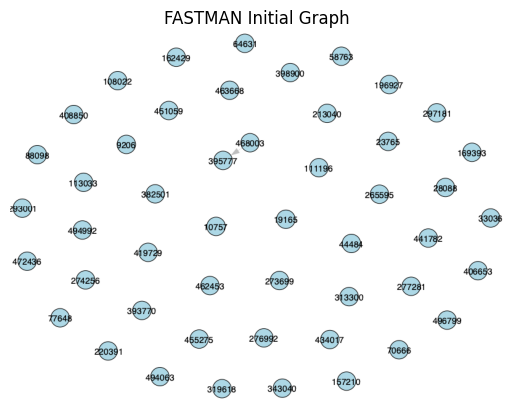

In [25]:
import cairo
import igraph as ig

# Select nodes
selected_node_ids = list(range(1, 50))  # Select the first 50 nodes

# Create the subgraph
subgraph = g.subgraph(selected_node_ids)

# Choose a layout (Fruchterman-Reingold for force-directed placement)
layout = subgraph.layout("fr")

# Define output directory and filename
output_dir = "figures"
output_file = os.path.join(output_dir, "fastman_initial_graph.png")

# Ensure output directory exists
os.makedirs(output_dir, exist_ok=True)

# Save the graph as an image using igraph's optimized plot
ig.plot(
    subgraph,
    target=output_file,  # Save instead of displaying immediately
    layout=layout,
    vertex_size=30,
    vertex_label=subgraph.vs["name"],
    edge_width=0.5,
    vertex_color="lightblue",  # Custom node color
    edge_color="gray",         # Custom edge color
    bbox=(800, 600),  # Image resolution
)

# Load and display the saved image using Matplotlib
img = plt.imread(output_file)
plt.imshow(img)
plt.axis("off")  # Hide axes
plt.title("FASTMAN Initial Graph")  # Optional: Add a title
plt.show()



# 2. 2nd Order Graph Creation

In this section, we derive  the 2nd order graph of sequential transactions. Which will represent relationships between **connected edges** rather than individual nodes. Instead of viewing direct transactions (`A → B`), this graph captures **indirect relationships** (`A → B → C`), grouping existing nodes and modifying their identifier values to reflect the relationship.

In [26]:
edges = pl.read_parquet(os.path.join(data_location, 
                                     'edges/src_date=2022-09-01/dst_date=2022-09-01/00000000.parquet'))

edges.head()

src_transaction,dst_transaction,src_date,dst_date,src_index,dst_index
u32,u32,date,date,u32,u32
317995,40,2022-09-01,2022-09-01,202094,172484
34239,40,2022-09-01,2022-09-01,157276,172484
90222,43,2022-09-01,2022-09-01,177805,178409
507533,143,2022-09-01,2022-09-01,171284,158993
243475,182,2022-09-01,2022-09-01,173873,160843


In [27]:
print(f"Number of edges: {edges.height}")


Number of edges: 17697


In [28]:
# # codi blanca, em donava error he fet servir el que està a continuació
# # Define the file locations
# os.makedirs(second_order_location, exist_ok=True)

# # Helper function to process parquet files and construct second-order edges
# def process_parquet_files():
#     # Create an empty DataFrame to accumulate results
#     all_edges = pl.DataFrame()

#     # Traverse the directories to find all parquet files
#     for src_date_dir in os.listdir(os.path.join(data_location, "edges")):
#         src_date_path = os.path.join(data_location, "edges", src_date_dir)
        
#         # Only proceed if it's a directory (for src_date)
#         if os.path.isdir(src_date_path):
#             # Get all dst_date subdirectories for the given src_date
#             for dst_date_dir in os.listdir(src_date_path):
#                 dst_date_path = os.path.join(src_date_path, dst_date_dir)
                
#                 # Process parquet files inside the dst_date subdirectories
#                 if os.path.isdir(dst_date_path):
#                     for parquet_file in os.listdir(dst_date_path):
#                         if parquet_file.endswith(".parquet"):
#                             parquet_file_path = os.path.join(dst_date_path, parquet_file)

#                             # Read the parquet file
#                             edges = pl.read_parquet(parquet_file_path)

#                             # Ensure that all necessary columns are strings
#                             edges = edges.with_columns([
#                                 pl.col("src_transaction").cast(pl.Utf8),
#                                 pl.col("dst_transaction").cast(pl.Utf8),
#                                 pl.col("src_index").cast(pl.Utf8),
#                                 pl.col("dst_index").cast(pl.Utf8)
#                             ])
                            
#                             # Rename columns for the left side of the join
#                             edges_left = edges.rename({col: f"{col}_left" for col in edges.columns})

#                             # Rename columns for the right side of the join
#                             edges_right = edges.rename({col: f"{col}_right" for col in edges.columns})

#                             # Perform the join
#                             joint_edges = edges_left.join(edges_right, left_on="dst_left", right_on="src_right")

#                             # Construct second-order edges with proper src/dst
#                             second_order_edges = (
#                                 joint_edges
#                                 .select([ 
#                                     # Construct src from left-side transaction (A>>B)
#                                     (pl.col("src_left") + ">>" + pl.col("dst_left")).alias("src"),
#                                     # Construct dst from right-side transaction (B>>C)
#                                     # dst_left = src_right
#                                     (pl.col("dst_left") + ">>" + pl.col("dst_right")).alias("dst"),
#                                     # Use timestamp from the right-side edge
#                                     pl.col("src_date_right").alias("moment")
#                                 ])
#                                 .unique()
#                             )

#                             # Concatenate the second-order edges to the all_edges DataFrame (this combines data from all parquet files)
#                             all_edges = all_edges.vstack(second_order_edges)

#     # After processing all files, save the accumulated DataFrame as partitioned parquet
#     all_edges.write_parquet(os.path.join(second_order_location), partition_by=["moment"])
    
#     return all_edges

# # Call the function to process the parquet files and create second-order edges
# second_order_edges = process_parquet_files()

# # Show the first few rows to verify
# second_order_edges.head()

In [29]:
import os
import polars as pl

# Define the file locations
os.makedirs(second_order_location, exist_ok=True)

# Helper function to process parquet files and construct second-order edges
def process_parquet_files():
    # Create an empty DataFrame to accumulate results
    all_edges = pl.DataFrame()

    # Traverse the directories to find all parquet files
    for src_date_dir in os.listdir(os.path.join(data_location, "edges")):
        src_date_path = os.path.join(data_location, "edges", src_date_dir)
        
        # Only proceed if it's a directory (for src_date)
        if os.path.isdir(src_date_path):
            # Get all dst_date subdirectories for the given src_date
            for dst_date_dir in os.listdir(src_date_path):
                dst_date_path = os.path.join(src_date_path, dst_date_dir)
                
                # Process parquet files inside the dst_date subdirectories
                if os.path.isdir(dst_date_path):
                    for parquet_file in os.listdir(dst_date_path):
                        if parquet_file.endswith(".parquet"):
                            parquet_file_path = os.path.join(dst_date_path, parquet_file)

                            # Read the parquet file
                            edges = pl.read_parquet(parquet_file_path)

                            # Ensure that all necessary columns are strings
                            edges = edges.with_columns([
                                pl.col("src_transaction").cast(pl.Utf8),
                                pl.col("dst_transaction").cast(pl.Utf8),
                                pl.col("src_index").cast(pl.Utf8),
                                pl.col("dst_index").cast(pl.Utf8)
                            ])
                            
                            # Rename columns for the left side of the join
                            edges_left = edges.rename({
                                "src_transaction": "src_transaction_left",
                                "dst_transaction": "dst_transaction_left",
                                "src_date": "src_date_left",
                                "dst_date": "dst_date_left",
                                "src_index": "src_index_left",
                                "dst_index": "dst_index_left"
                            })

                            # Rename columns for the right side of the join
                            edges_right = edges.rename({
                                "src_transaction": "src_transaction_right",
                                "dst_transaction": "dst_transaction_right",
                                "src_date": "src_date_right",
                                "dst_date": "dst_date_right",
                                "src_index": "src_index_right",
                                "dst_index": "dst_index_right"
                            })

                            # Perform the join (connecting dst_transaction from left with src_transaction from right)
                            joint_edges = edges_left.join(
                                edges_right, 
                                left_on="dst_transaction_left", 
                                right_on="src_transaction_right"
                            )

                            # Construct second-order edges with proper src/dst
                            second_order_edges = (
                                joint_edges
                                .select([
                                    # Construct src from left-side transaction (A>>B)
                                    (pl.col("src_transaction_left") + ">>" + pl.col("dst_transaction_left")).alias("src"),
                                    # Construct dst from right-side transaction (B>>C)
                                    (pl.col("dst_transaction_left") + ">>" + pl.col("dst_transaction_right")).alias("dst"),
                                    # Use timestamp from the right-side edge
                                    pl.col("src_date_right").alias("moment")
                                ])
                                .unique()
                            )

                            # Concatenate the second-order edges to the all_edges DataFrame
                            all_edges = all_edges.vstack(second_order_edges)

    # Save the accumulated DataFrame as partitioned parquet (if it has data)
    if all_edges.height > 0:
        all_edges.write_parquet(os.path.join(second_order_location), partition_by=["moment"])
    else:
        print("No second-order edges found. Skipping parquet write.")
    
    return all_edges

# Call the function to process the parquet files and create second-order edges
second_order_edges = process_parquet_files()

# Show the first few rows to verify
print(second_order_edges.head())


shape: (5, 3)
┌────────────────┬────────────────┬────────────┐
│ src            ┆ dst            ┆ moment     │
│ ---            ┆ ---            ┆ ---        │
│ str            ┆ str            ┆ date       │
╞════════════════╪════════════════╪════════════╡
│ 499551>>197895 ┆ 197895>>459277 ┆ 2022-09-06 │
│ 300397>>377982 ┆ 377982>>61426  ┆ 2022-09-06 │
│ 321851>>149716 ┆ 149716>>162436 ┆ 2022-09-06 │
│ 295542>>396067 ┆ 396067>>145559 ┆ 2022-09-06 │
│ 471455>>423239 ┆ 423239>>457964 ┆ 2022-09-06 │
└────────────────┴────────────────┴────────────┘


In [30]:
print(f"Number of edges: {second_order_edges.height}")


Number of edges: 22427


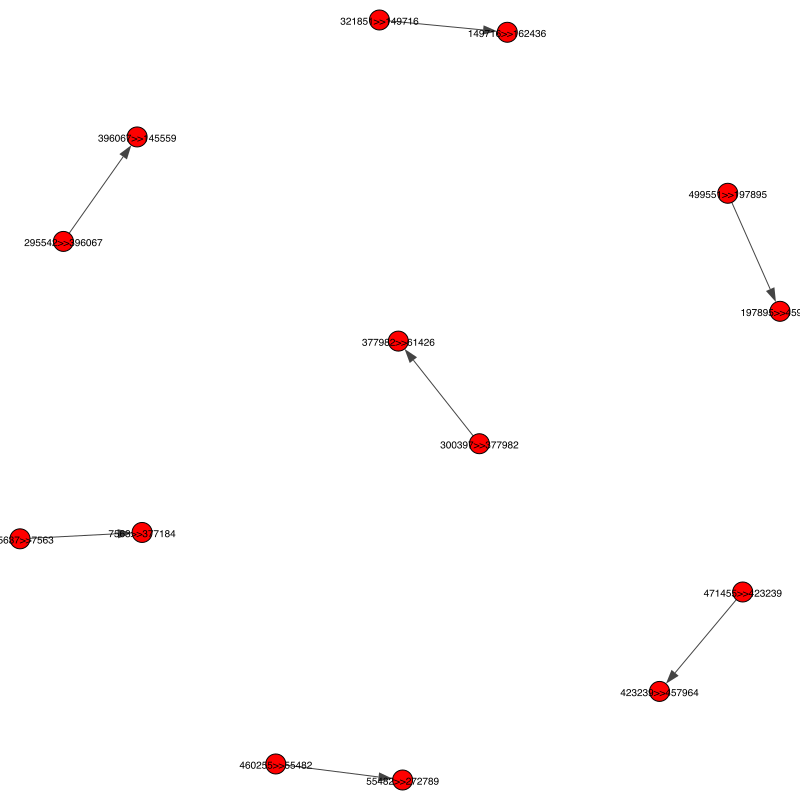

In [31]:
from igraph import Graph, plot
import pandas as pd
import pyarrow 

# Assuming `second_order_edges` is a Polars DataFrame already loaded and processed
# Sample the first 7 edges (adjust as necessary)
sample_edges = second_order_edges.head(7).to_pandas()

# Create an igraph graph from the edge list (using 'src' and 'dst')
g = Graph.TupleList(
    sample_edges[["src", "dst"]].itertuples(index=False),
    directed=True
)

# Add edge attributes (e.g., 'moment' from the sample edges)
g.es["moment"] = sample_edges["moment"].tolist()

# Set node labels
g.vs["label"] = g.vs["name"]

# Define visual style for the plot
visual_style = {
    "vertex_size": 20,  # size of the vertices
    "vertex_label_size": 10,  # size of the vertex labels
    "bbox": (800, 800),  # size of the plot
    "margin": 20,  # margin around the plot
}

# Use a force-directed layout (Fruchterman-Reingold)
layout_coords = g.layout("fr")  # or "kk" for Kamada-Kawai
visual_style["layout"] = layout_coords

# Plot the graph
plot(g, **visual_style)


In [32]:
import polars as pl
import os

# Load the original transactions
def count_nodes_before_after():
    original_nodes = set()

    # Read and process all parquet files
    for src_date_dir in os.listdir(os.path.join(data_location, "edges")):
        src_date_path = os.path.join(data_location, "edges", src_date_dir)
        if os.path.isdir(src_date_path):
            for dst_date_dir in os.listdir(src_date_path):
                dst_date_path = os.path.join(src_date_path, dst_date_dir)
                if os.path.isdir(dst_date_path):
                    for parquet_file in os.listdir(dst_date_path):
                        if parquet_file.endswith(".parquet"):
                            parquet_file_path = os.path.join(dst_date_path, parquet_file)
                            
                            # Read parquet file
                            edges = pl.read_parquet(parquet_file_path)
                            
                            # Add unique nodes from src_transaction and dst_transaction
                            original_nodes.update(edges["src_transaction"].to_list())
                            original_nodes.update(edges["dst_transaction"].to_list())

    print(f"Unique nodes BEFORE processing: {len(original_nodes)}")

    # Process second-order edges
    second_order_edges = process_parquet_files()

    # Extract new nodes after processing
    processed_nodes = set()
    processed_nodes.update(second_order_edges["src"].to_list())
    processed_nodes.update(second_order_edges["dst"].to_list())

    print(f"Unique nodes AFTER processing: {len(processed_nodes)}")

# Run the function to compare node counts
count_nodes_before_after()


Unique nodes BEFORE processing: 220924
Unique nodes AFTER processing: 23710


# 3. Weight calculation through the 2nd order graph

(and applying the weights to the graph in the end of section 2.)

In this step, we assign weights to pairs of transactions to determine meaningful sequences. The weight between two nodes, $ W(v_i, v_j) $, is the maximum of the following two calculations:

$$
P_{i,j} = \frac{a_i}{a_j} \bigg/ \sum_{s \in S} \frac{a_i}{a_s}
$$

where $ S $ is the set of all nodes at which an edge from $ i $ arrives.

Similarly, another weight calculation is defined as:

$$
P'_{i,j} = \frac{a_j}{a_i} \bigg/ \sum_{s \in D} \frac{a_j}{a_s}
$$

where $ D $ is the set of all nodes from which $ j $ receives an edge.

Finally, the weight between nodes is determined as:

$$
W(v_i, v_j) = \max(P_{i,j}, P'_{i,j})
$$


Steps explained:

1. We create the dataframe `edges_with_amount` which has the columns: 
    * `src` and `dst`, 
    * `amount_src`, `amount_dst`

In [33]:
# # Define input and output locations
# edges_location = os.path.join(data_location, "edges")
# nodes_location = os.path.join(data_location, "nodes")
# weighted_edges_location = os.path.join(data_location, "edges-weighted")
# os.makedirs(weighted_edges_location, exist_ok=True)

# # Function to compute edge weights
# def compute_edge_weights(edges_df, nodes_df):
#     # Join edges with node amounts
#     edges_with_amounts = (
#         edges_df
#         .join(nodes_df.select(["id", "amount"]), left_on="src", right_on="id", how="left")
#         .rename({"amount": "amount_src"})
#         .join(nodes_df.select(["id", "amount"]), left_on="dst", right_on="id", how="left")
#         .rename({"amount": "amount_dst"})
#     )
    
#     # Compute ratios
#     edges_with_amounts = edges_with_amounts.with_columns([
#         (pl.col("amount_src") / pl.col("amount_dst")).alias("ratio_ij"),
#         (pl.col("amount_dst") / pl.col("amount_src")).alias("ratio_ji")
#     ])
    
#     # Compute sums for normalizing
#     sum_ij = edges_with_amounts.group_by("src").agg(pl.sum("ratio_ij").alias("sum_ij"))
#     sum_ji = edges_with_amounts.group_by("dst").agg(pl.sum("ratio_ji").alias("sum_ji"))
    
#     # Join sums
#     edges_with_amounts = (
#         edges_with_amounts
#         .join(sum_ij, on="src", how="left")
#         .join(sum_ji, on="dst", how="left")
#         .fill_null(0)  # Ensure no null values
#     )
    
#     # Compute probabilities
#     edges_with_probs = edges_with_amounts.with_columns([
#         pl.when(pl.col("sum_ij") > 0).then(pl.col("ratio_ij") / pl.col("sum_ij")).otherwise(0).alias("p_ij"),
#         pl.when(pl.col("sum_ji") > 0).then(pl.col("ratio_ji") / pl.col("sum_ji")).otherwise(0).alias("p_ji")
#     ])
    
#     # Compute final weights
#     edges_with_weights = edges_with_probs.with_columns([
#         pl.max_horizontal(["p_ij", "p_ji"]).alias("weight")
#     ]).select(["src", "dst", "weight", "src_date", "dst_date"])
    
#     return edges_with_weights

# # Process all edge partitions
# for src_date_dir in os.listdir(edges_location):
#     src_date_path = os.path.join(edges_location, src_date_dir)
#     if os.path.isdir(src_date_path):
#         for dst_date_dir in os.listdir(src_date_path):
#             dst_date_path = os.path.join(src_date_path, dst_date_dir)
#             if os.path.isdir(dst_date_path):
                
#                 # Load edges
#                 edges_files = [os.path.join(dst_date_path, f) for f in os.listdir(dst_date_path) if f.endswith(".parquet")]
#                 edges_df = pl.read_parquet(edges_files)
                
#                 # Load corresponding node data
#                 src_nodes_path = os.path.join(nodes_location, f"transaction_date={src_date_dir.split('=')[1]}")
#                 dst_nodes_path = os.path.join(nodes_location, f"transaction_date={dst_date_dir.split('=')[1]}")
#                 node_files = [os.path.join(src_nodes_path, f) for f in os.listdir(src_nodes_path) if f.endswith(".parquet")]
#                 node_files += [os.path.join(dst_nodes_path, f) for f in os.listdir(dst_nodes_path) if f.endswith(".parquet")]
#                 nodes_df = pl.read_parquet(node_files)
                
#                 # Compute weights
#                 weighted_edges = compute_edge_weights(edges_df, nodes_df)
                
#                 # Save partitioned
#                 save_path = os.path.join(weighted_edges_location, f"src_date={src_date_dir.split('=')[1]}", f"dst_date={dst_date_dir.split('=')[1]}")
#                 os.makedirs(save_path, exist_ok=True)
#                 weighted_edges.write_parquet(os.path.join(save_path, "00000000.parquet"))



In [34]:
import os
import polars as pl

# Define input and output locations
edges_location = os.path.join(data_location, "edges")
nodes_location = os.path.join(data_location, "nodes")
weighted_edges_location = os.path.join(data_location, "edges-weighted")
os.makedirs(weighted_edges_location, exist_ok=True)

# Function to compute edge weights
def compute_edge_weights(edges_df, nodes_df):
    # Join edges with node amounts
    edges_with_amounts = (
        edges_df
        .join(nodes_df.select(["id", "amount"]), left_on="src_transaction", right_on="id", how="left")
        .rename({"amount": "amount_src"})
        .join(nodes_df.select(["id", "amount"]), left_on="dst_transaction", right_on="id", how="left")
        .rename({"amount": "amount_dst"})
    )

    # Compute P_{i,j}
    edges_with_amounts = edges_with_amounts.with_columns([
        pl.when(pl.col("amount_dst") > 0).then(pl.col("amount_src") / pl.col("amount_dst")).otherwise(0).alias("ratio_ij")
    ])

    sum_ij = edges_with_amounts.group_by("src_transaction").agg(pl.sum("ratio_ij").alias("sum_ij"))
    edges_with_amounts = edges_with_amounts.join(sum_ij, on="src_transaction", how="left").fill_null(0)

    edges_with_amounts = edges_with_amounts.with_columns([
        pl.when(pl.col("sum_ij") > 0).then(pl.col("ratio_ij") / pl.col("sum_ij")).otherwise(0).alias("p_ij")
    ])

    # Compute P'_{i,j}
    edges_with_amounts = edges_with_amounts.with_columns([
        pl.when(pl.col("amount_src") > 0).then(pl.col("amount_dst") / pl.col("amount_src")).otherwise(0).alias("ratio_ji")
    ])

    sum_ji = edges_with_amounts.group_by("dst_transaction").agg(pl.sum("ratio_ji").alias("sum_ji"))
    edges_with_amounts = edges_with_amounts.join(sum_ji, on="dst_transaction", how="left").fill_null(0)

    edges_with_amounts = edges_with_amounts.with_columns([
        pl.when(pl.col("sum_ji") > 0).then(pl.col("ratio_ji") / pl.col("sum_ji")).otherwise(0).alias("p_ji")
    ])

    # Compute final weight
    edges_with_weights = edges_with_amounts.with_columns([
        pl.max_horizontal(["p_ij", "p_ji"]).alias("weight")
    ]).select(["src_transaction", "dst_transaction", "weight", "src_date", "dst_date"])

    return edges_with_weights

# Process all edge partitions
for src_date_dir in os.listdir(edges_location):
    src_date_path = os.path.join(edges_location, src_date_dir)
    if os.path.isdir(src_date_path):
        for dst_date_dir in os.listdir(src_date_path):
            dst_date_path = os.path.join(src_date_path, dst_date_dir)
            if os.path.isdir(dst_date_path):
                
                # Load edges
                edges_files = [os.path.join(dst_date_path, f) for f in os.listdir(dst_date_path) if f.endswith(".parquet")]
                edges_df = pl.read_parquet(edges_files)
                
                # Load corresponding node data
                src_nodes_path = os.path.join(nodes_location, f"transaction_date={src_date_dir.split('=')[1]}")
                dst_nodes_path = os.path.join(nodes_location, f"transaction_date={dst_date_dir.split('=')[1]}")
                node_files = []
                
                if os.path.exists(src_nodes_path):
                    node_files += [os.path.join(src_nodes_path, f) for f in os.listdir(src_nodes_path) if f.endswith(".parquet")]
                if os.path.exists(dst_nodes_path):
                    node_files += [os.path.join(dst_nodes_path, f) for f in os.listdir(dst_nodes_path) if f.endswith(".parquet")]
                
                if node_files:
                    nodes_df = pl.read_parquet(node_files)

                    # Compute weights
                    weighted_edges = compute_edge_weights(edges_df, nodes_df)
                    
                    # Save partitioned
                    save_path = os.path.join(weighted_edges_location, f"src_date={src_date_dir.split('=')[1]}", f"dst_date={dst_date_dir.split('=')[1]}")
                    os.makedirs(save_path, exist_ok=True)
                    weighted_edges.write_parquet(os.path.join(save_path, "00000000.parquet"))
                else:
                    print(f"No node data found for {src_date_dir} or {dst_date_dir}, skipping weight computation.")


In [35]:
print(f"Unique src_transactions: {weighted_edges['src_transaction'].n_unique()}")
print(f"Unique dst_transactions: {weighted_edges['dst_transaction'].n_unique()}")


Unique src_transactions: 2
Unique dst_transactions: 3


In [36]:
weighted_edges.unique()

src_transaction,dst_transaction,weight,src_date,dst_date
u32,u32,f64,date,date
1198477,1026577,0.25,2022-09-18,2022-09-18
2323102,876892,0.25,2022-09-18,2022-09-18
2323102,2134777,0.25,2022-09-18,2022-09-18


# 4. Community detection

In [ ]:
import leidenalg as la
import networkx as nx

relative_path = os.path.join("..", "data", "edges-weighted", "src_date=2022-09-01", "dst_date=2022-09-01", "00000000.parquet")

# Load the weighted edges from Parquet using Polars
df = pl.read_parquet(relative_path)

# Convert only necessary columns for graph construction
edges_df = df.select(["src_transaction", "dst_transaction", "weight"]).to_pandas()

# Create a directed graph in iGraph (avoid using DataFrame directly if not necessary)
graph = ig.Graph.TupleList(edges_df.itertuples(index=False, name=None), directed=True, weights=True)

# Run Leiden community detection using modularity partitioning with fewer iterations
communities = la.find_partition(graph, la.ModularityVertexPartition, weights="weight", n_iterations=3)

# Assign community labels to the nodes in the igraph
graph.vs["community"] = communities.membership

# Build a NetworkX graph for visualization (efficiently using community labels directly)
communities_graph = nx.DiGraph()

# Add nodes and edges to the NetworkX graph
for edge in edges_df.itertuples(index=False):
    communities_graph.add_edge(edge.src_transaction, edge.dst_transaction)

# Create a community label mapping for NetworkX nodes
community_labels = {graph.vs[i]["name"]: communities.membership[i] for i in range(len(graph.vs))}

# Map the community labels to the NetworkX graph nodes
node_colors = [community_labels[node] for node in communities_graph.nodes()]

In [63]:
total_communities = len(set(communities.membership))
print(f"Total number of communities detected: {total_communities}")

Total number of communities detected: 9558


Not enough valid communities available.


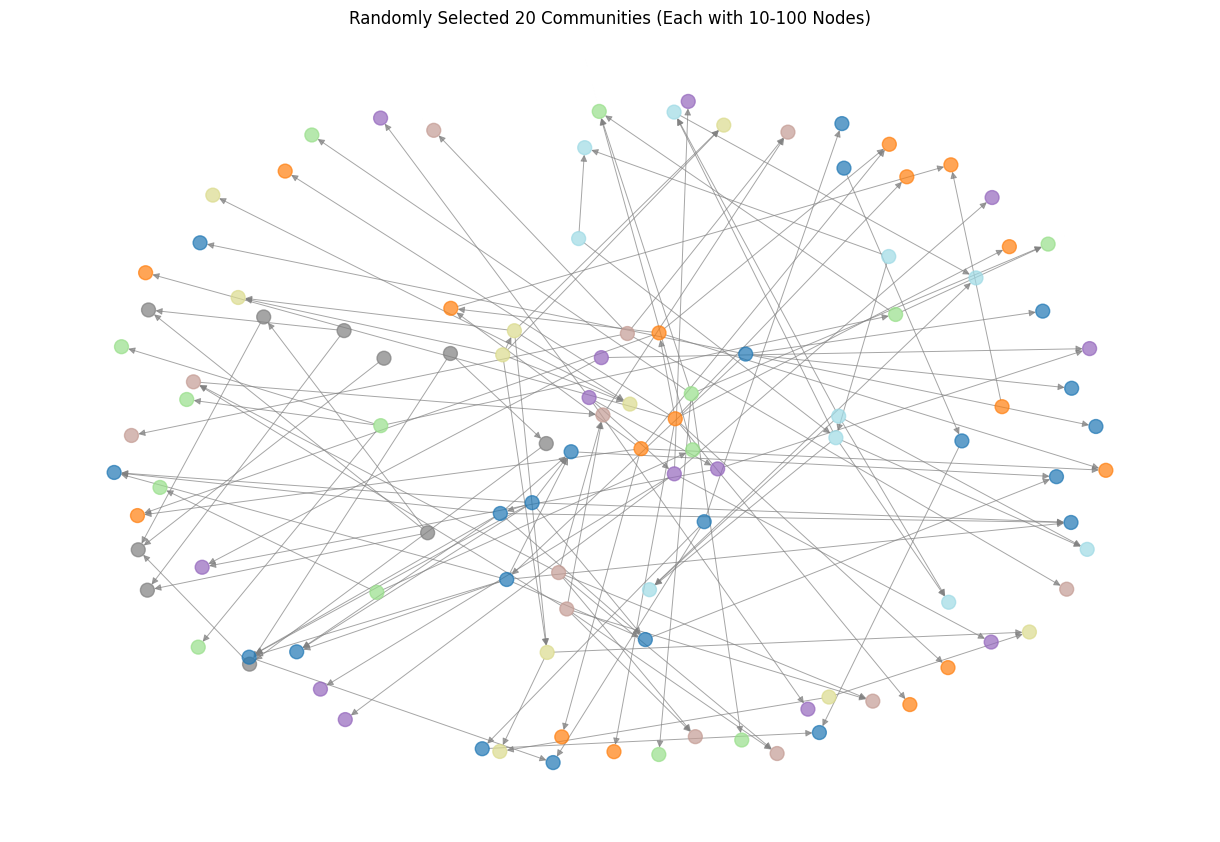

In [88]:
import os
import polars as pl
import igraph as ig
import leidenalg as la
import networkx as nx
import matplotlib.pyplot as plt
import random

# Load the weighted edges from Parquet using Polars
relative_path = os.path.join("..", "data", "edges-weighted", "src_date=2022-09-01", "dst_date=2022-09-01", "00000000.parquet")
df = pl.read_parquet(relative_path)

# Convert necessary columns for graph construction
edges_df = df.select(["src_transaction", "dst_transaction", "weight"]).to_pandas()

# Create a directed graph in iGraph
graph = ig.Graph.TupleList(edges_df.itertuples(index=False, name=None), directed=True, weights=True)

# Assign unique node names to avoid indexing issues
graph.vs["name"] = [str(i) for i in range(graph.vcount())]

# Run Leiden community detection using modularity partitioning
communities = la.find_partition(graph, la.ModularityVertexPartition, weights="weight", n_iterations=3)

# Assign community labels to nodes
graph.vs["community"] = communities.membership

# Group nodes by community
community_nodes = {}
for node_id, comm in enumerate(communities.membership):
    community_nodes.setdefault(comm, []).append(node_id)

# Filter communities that have between 10 and 100 nodes
valid_communities = {c: nodes for c, nodes in community_nodes.items() if 10 <= len(nodes) <= 100}

# Step 2: Randomly select 20 such communities
if len(valid_communities) < 20:
    print("Not enough valid communities available.")
    selected_communities = list(valid_communities.values())  # Use all available
else:
    selected_communities = random.sample(list(valid_communities.values()), 20)

# Collect selected nodes
selected_nodes = [node for community in selected_communities for node in community]

# Step 3: Extract subgraph for selected nodes
subgraph = graph.subgraph(selected_nodes)

# Convert iGraph subgraph to NetworkX for visualization
nx_graph = nx.DiGraph()
edges = [(subgraph.vs[edge.source]["name"], subgraph.vs[edge.target]["name"]) for edge in subgraph.es]
nx_graph.add_edges_from(edges)

# Assign colors to nodes based on their community
node_community_map = {subgraph.vs[node]["name"]: subgraph.vs[node]["community"] for node in range(len(subgraph.vs))}
node_colors = [node_community_map[node] for node in nx_graph.nodes()]

# Step 4: Visualize the subgraph using NetworkX
plt.figure(figsize=(12, 8))
pos = nx.spring_layout(nx_graph, k=0.6, seed=42)  # Layout for better spacing
nx.draw(nx_graph, pos, with_labels=False, node_size=100, node_color=node_colors, cmap=plt.cm.tab20, alpha=0.7, edge_color="grey", width=0.7)

# Add the title and display the plot
plt.title("Randomly Selected 20 Communities (Each with 10-100 Nodes)")
plt.show()


# 5. Anomalous comunity detection